<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/onestop_data_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
import numpy as np

In [0]:
data_dir = "data/"
# Define sensors to process
sensor_name_list = ["RWS01_MONIBAS_0021hrl0414ra", "RWS01_MONIBAS_0021hrl0403ra", "RWS01_MONIBAS_0021hrl0409ra", "RWS01_MONIBAS_0021hrl0420ra", "RWS01_MONIBAS_0021hrl0426ra"]

### ------------------------------------------------------------ START OF MESSING AROUND ------------------------------------------------------------

In [0]:
def dateparse (time_in_secs):
    # Unix/epoch time to "YYYY-MM-DD HH:MM:SS"
    return datetime.datetime.fromtimestamp(float(time_in_secs))

df = pd.read_csv("data/ndw_raw/RWS01_MONIBAS_0021hrl0414ra.csv"), header = None, \
                         usecols = [0, 86, 87], names = ["timestamp", "speed", "flow"], \
                         index_col = "timestamp", parse_dates = True, date_parser = dateparse)

In [0]:
hours = df.resample('H').agg({'speed': np.mean, 'flow': np.mean})

In [0]:
hours2 = hours[(hours.index.hour == 4)]
hours2.index = hours2.index.tz_localize('UTC').tz_convert('CET')

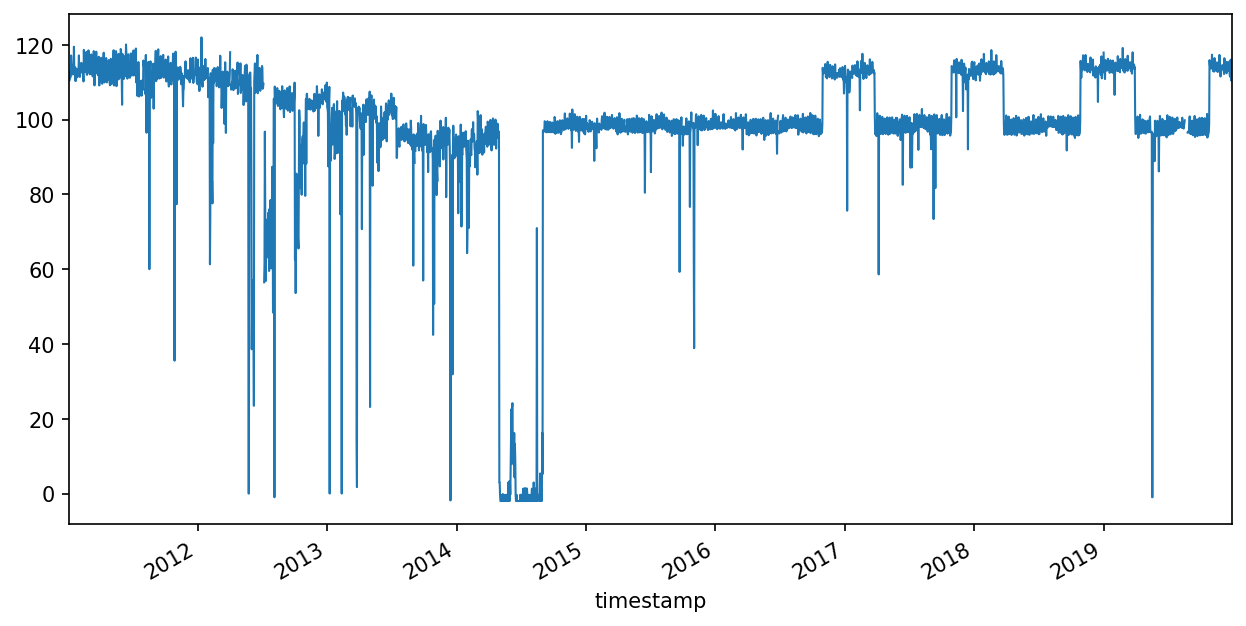

In [90]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 150
hours2.speed.plot(lw = 1)

In [0]:
def repair_datetime_index(df, freq = "T"):
    df = df.loc[~df.index.duplicated(keep = "first")] # remove duplicate date time indexes
    df = df.reindex(pd.date_range(start = df.index.min(), end = df.index.max(), freq = freq)) # add missing date time indexes

### ------------------------------------------------------------ END OF MESSING AROUND ------------------------------------------------------------

### Clean sensor data

In [0]:
import datetime
def dateparse (time_in_secs):
    # Unix/epoch time to "YYYY-MM-DD HH:MM:SS"
    return datetime.datetime.fromtimestamp(float(time_in_secs))

def repair_datetime_index(df, freq = "T"):
    df = df.loc[~df.index.duplicated(keep = "first")] # remove duplicate date time indexes
    df = df.reindex(pd.date_range(start = df.index.min(), end = df.index.max(), freq = freq)) # add missing date time indexes
    
    return df

def fix_values(df):
    # The order of these operations is currently important! Pay attention when making changes
    df["speed_limit"] = np.where((df.index.hour < 19) & (df.index.hour >= 6), 100, 120)
    df.loc[df.flow < 0, "flow"] = np.nan # flow is either -2 (missing data) or 0 or positive. -2 to nan
    df.loc[df.speed < -1, "speed"] = np.nan # -2 (missing data) as well as oddities (-1.33, an average over -2 and -1 lanes?) to nan 
    df.speed.mask(df.speed == -1, df.speed_limit + 10, inplace = True) # -1 means no cars, setting it to speed limit + 10
    df.loc[(df.speed < 0) & (df.speed > -1), "speed"] = 0 # anything else below zero is between 0 and -1, occuring when some lanes have non-moving cars while others have have no cars.
    df.speed.mask(df.speed > df.speed_limit + 10, df.speed_limit, inplace = True) # cap speed at speed_limit + 10, since higher speed dosn't add to representation
    
    return df

import os
def reduce_cols(sensors, path_in = "data/ndw_raw/", path_out = "data/"):
    sensor_df_list = list()
    for sensor in sensors:
        df = pd.read_csv(os.path.join(path_in, sensor + ".csv"), header = None, \
                         usecols = [0, 86, 87], names = ["timestamp", "speed", "flow"], \
                         index_col = "timestamp", parse_dates = True, date_parser = dateparse)
        df.flow /= 60 # change flow unit to min^-1
        df = repair_datetime_index(df)
        df = fix_values(df)        
        #df.to_csv(path_out + sensor)
        sensor_df_list.append(df)

    return sensor_df_list

In [0]:
sensor_df_list = reduce_cols(sensor_name_list)

In [0]:
testdf = sensor_df_list[0]

,speed,flow,speed_limit
2019-12-13 05:00:00,108.400000,59.0,120
2019-12-13 05:01:00,98.250000,46.0,120
2019-12-13 05:02:00,100.600000,52.0,120
2019-12-13 05:03:00,95.800000,39.0,120
2019-12-13 05:04:00,97.800000,70.0,120
2019-12-13 05:05:00,98.000000,54.0,120
2019-12-13 05:06:00,98.000000,67.0,120
2019-12-13 05:07:00,97.200000,84.0,120
2019-12-13 05:08:00,97.600000,67.0,120
2019-12-13 05:09:00,97.000000,95.0,120


### Join Sensors

In [0]:
def join_sensors(sensor_df_list, sensor_name_list):
    combined_df = pd.DataFrame({"timestamp": pd.date_range(start = "2011-01-01", end = "2019-12-31", freq = "T")})
    combined_df.set_index("timestamp", drop = True, inplace = True)
    d = {}
    for i, sensor in enumerate(sensor_df_list):
        # only add speed limit on the final sensor
        if i == len(sensor_df_list) - 1:
            d[sensor_name_list[i]] = sensor_df_list[i]
            combined_df = combined_df.join(d[sensor_name_list[i]], how = "outer", rsuffix = '_' + sensor_name_list[i])
        else:
            d[sensor_name_list[i]] = sensor_df_list[i].iloc[:, :2]
            combined_df = combined_df.join(d[sensor_name_list[i]], how = "outer", rsuffix = "_" + sensor_name_list[i])
    combined_df.dropna(how = "all", axis = 0, inplace = True) # this works in all cases because speed_limit is never NA on a sensor df
    
    return combined_df

In [0]:
# Join sensors to one table
df = join_sensors(sensor_df_list, sensor_name_list)

# Rename and reorder columns
df.rename({"speed_RWS01_MONIBAS_0021hrl0403ra": "speed_-2", "speed_RWS01_MONIBAS_0021hrl0409ra": "speed_-1",\
           "speed_RWS01_MONIBAS_0021hrl0420ra": "speed_+1", "speed_RWS01_MONIBAS_0021hrl0426ra": "speed_+2",\
           "flow_RWS01_MONIBAS_0021hrl0403ra": "flow_-2", "flow_RWS01_MONIBAS_0021hrl0409ra": "flow_-1",\
           "flow_RWS01_MONIBAS_0021hrl0420ra": "flow_+1", "flow_RWS01_MONIBAS_0021hrl0426ra": "flow_+2"\
           }, axis = 1, inplace = True)
col_order = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit"]
df = df[col_order]

# Save table to csv
#df.to_csv(data_dir + "combined_df.csv")

In [0]:
df.head()

,speed,flow,speed_-2,speed_-1,speed_+1,speed_+2,flow_-2,flow_-1,flow_+1,flow_+2,speed_limit
2011-01-03 00:00:00,122.000000,8.0,100.000000,120.000000,118.5,129.750000,8.0,6.0,4.0,6.0,120.0
2011-01-03 00:01:00,120.000000,5.0,115.000000,126.333333,118.0,104.000000,18.0,6.0,5.0,2.0,120.0
2011-01-03 00:02:00,111.000000,2.0,112.666667,104.000000,91.0,112.666667,14.0,2.0,4.0,8.0,120.0
2011-01-03 00:03:00,105.333333,10.0,118.000000,108.666667,120.0,120.000000,14.0,6.0,9.0,10.0,120.0
2011-01-03 00:04:00,120.000000,8.0,105.500000,121.000000,127.5,117.500000,21.0,13.0,7.0,5.0,120.0


### Impute data

In [0]:
cols = col_order
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

In [0]:
# Where values are missing in one or more sensors, but are present in others, impute with mean of others
def fill_na_row_mean(df):
    row_avgs = df.mean(axis = 1).values.reshape(-1, 1)
    df = df.fillna(0) + df.isna().values * row_avgs
    return df

In [0]:
speed_df = fill_na_row_mean(df[speed_cols])
flow_df = fill_na_row_mean(df[flow_cols])

In [0]:
df = speed_df.join(flow_df, how = "inner").join(df[["speed_limit"]], how ="inner")

In [0]:
# Interpolate null vals for the first week of data of speed and flow cols
def interpolate_week(df, cols):
    week = 7 * 24 * 60
    for col in cols: 
        df.iloc[:week, df.columns.get_loc(col)] = df[col][:week].interpolate(method = "time")
    return df

# Replace remaining nulls with value from 1 week previous
def shift_week(df, cols):
    # Use RangeIndex for the this operation
    df["timestamp"] = df.index
    df.reset_index(drop = True, inplace = True)
    week = 7 * 24 * 60
    for col in cols:
        col_index = df.columns.get_loc(col)
        for row in df.itertuples():
            if np.isnan(row[col_index + 1]):
                df.iat[row[0], col_index] = df.iat[(row[0] - week), col_index]
    # Return to DateTimeIndex again
    df.set_index(pd.to_datetime(df.timestamp.values), inplace = True) 
    df.drop("timestamp", axis = 1, inplace = True)
    return df

In [0]:
df = interpolate_week(df, cols)
df = shift_week(df, cols)
#df.to_csv("data/df_imputed_week_shift.csv")

In [0]:
import holidays
df["weekend"] = np.where(df.index.weekday > 4, 1, 0).astype(np.int16)
df["holiday"] = np.array([int(x in holidays.NL()) for x in df.index]).astype(np.int16)
df["speed_limit"] =  np.where(df.speed_limit > 110, 1, 0)

In [0]:
df.to_csv("data/df_imputed_week_shift_added_holiday_weekends_speed_limit_plus_10.csv")